# 1. Build an object detection model using pytorch

In [57]:
# Importing the required libraries
import os
import io
import random
import numpy as np
import pandas as pd

import cv2
from tqdm import tqdm

from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [58]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [59]:
#device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [60]:
#Train transform
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
#Validation transform
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [61]:
#!pip install timm

In [62]:
#Defining the Network
class ObjectDetection(nn.Module):
    def __init__(self):
        super(ObjectDetection, self).__init__()
        #Load pretrained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)
        #Replace the last layer 
        self.resnet.fc = nn.Identity()
        #Flatten Output
        self.flatten = nn.Flatten()
        #For Classification
        self.classifier = nn.Linear(2048, 61)
        #For Prediction
        self.bbox = nn.Linear(2048, 4)

    #Forward Pass
    def forward(self, x):
        x = self.resnet(x)
        x = self.flatten(x)
        x_c = self.classifier(x)
        x_b = self.bbox(x)

        # Return the class probabilities and bounding box coordinates
        return x_c, x_b

In [63]:
# Custom dataset
class CowstallDataset(Dataset):
    
    def __init__(self, dataset, img_dir, transform = None):
      super().__init__()
      self.dataset = dataset
      self.img_dir = img_dir
      self.transform = transform
             
    def __len__(self):
      return len(self.dataset)

    def __getitem__(self, idx):
      # Get image path from filename
      image_path = os.path.join(self.img_dir, self.dataset.iloc[idx,0])
      #Image Preprocessing  
      image = cv2.imread(image_path,cv2.IMREAD_UNCHANGED)
      image = cv2.resize(image, (299,299))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
      image /= 255.0
      image = self.transform(image)
      
      #Label Extraction
      labels = torch.tensor(int(self.dataset.iloc[idx,5]))

      #Bounding boxes position Calculation
      bound_boxes = self.dataset[['box_position_1', 'box_position_2', 'box_position_3', 'box_position_4']].values[idx]
      bound_boxes[2] = bound_boxes[0] + bound_boxes[2]
      bound_boxes[3] = bound_boxes[1] + bound_boxes[3]
      bound_boxes = torch.as_tensor(bound_boxes, dtype=torch.float32)

      return image, labels, bound_boxes 
        

In [64]:
#Reading training images
train_url="https://raw.githubusercontent.com/YoushanZhang/Cow_stall_number/main/Train.csv"
df_train = pd.read_csv(train_url)
df_train.fillna(0, inplace=True)
df_train.head()

,imageFilename,box_position_1,box_position_2,box_position_3,box_position_4,class_names
0,GH030066_4679.png,287.0,116.0,25.0,23.0,29
1,GH020058_19383.png,275.0,58.0,23.0,24.0,44
2,GH030061_1269.png,306.0,74.0,26.0,25.0,13
3,GH020058_17235.png,0.0,0.0,0.0,0.0,0
4,GH020058_18319.png,288.0,55.0,23.0,23.0,42


In [65]:
#Reading test images 
df_test = pd.read_csv("https://raw.githubusercontent.com/YoushanZhang/Cow_stall_number/main/Test.csv")
df_test.fillna(0, inplace=True)
df_test.head()
len(df_test)

261

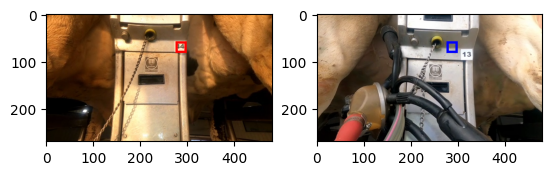

In [66]:
#Random Image
img = read_image("/content/drive/MyDrive/Colab Notebooks/Project 2 Deep Learning & NN/Stall_num_images/GH020058_19383.png")
img1= read_image("/content/drive/MyDrive/Colab Notebooks/Project 2 Deep Learning & NN/Stall_num_images/GH030061_1269.png")

#Defining the bounding box 
bbox = [275, 58, 298, 82]
bbox = torch.tensor(bbox)
bbox = bbox.unsqueeze(0)
bbox1 = [306,74,26,25]
bbox1 = torch.tensor(bbox)
bbox1 = bbox.unsqueeze(0)
  
# draw bounding box and fill color
img = draw_bounding_boxes(img, bbox, width=5,
                          colors="red")

img1 = draw_bounding_boxes(img1, bbox, width=5,
                          colors="blue")
# transform this image to PIL image
img = torchvision.transforms.ToPILImage()(img)
img1 = torchvision.transforms.ToPILImage()(img1)

# display output
#img.show()
plt.subplot(2,2,1)
plt.imshow(img)
plt.subplot(2,2,2)
plt.imshow(img1)

In [67]:
#Train-Val Split
train_set, val_set = train_test_split(df_train, test_size=0.10, random_state=100, shuffle=True)


In [68]:
#Lengths of Train and Validation Sets
print(len(train_set))
print(len(val_set))

937
105


In [69]:
#Image Directory
img_dir = "/content/drive/MyDrive/Colab Notebooks/Project 2 Deep Learning & NN/Stall_num_images"

#Calling the Custom Dataset
train_dataset = CowstallDataset(train_set, img_dir, train_transform)
valid_dataset = CowstallDataset(val_set, img_dir, val_transform)

#Trian and Validation DataLoaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
)

In [70]:
#Applying transform 
test_transform = transforms.Compose([transforms.ToTensor()])

In [71]:
#Test Dataloader
test_dataset = CowstallDataset(df_test, img_dir, test_transform)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=261,
    shuffle=False,
    num_workers=4,
)

In [72]:
#Moving the model to GPU
model = ObjectDetection().to(device)
#Directory path
dir_path = '/content/drive/MyDrive/Colab Notebooks/Project 2 Deep Learning & NN'

#Create the directory if it does not exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

#Providing the file path and name
file_path = os.path.join(dir_path, 'model50_final.pt')

#Saving the model to the specified path
torch.save(model, file_path)

#Loading the model from the saved path
model = torch.load('/content/drive/MyDrive/Colab Notebooks/Project 2 Deep Learning & NN/model50_final.pt')

In [73]:
#Instantiating the loss functions
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.MSELoss()

In [74]:
#Function to optimize the model stepwise
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr


In [75]:
#List of paramets that is to be trained
params = [p for p in model.parameters() if p.requires_grad]


In [76]:
#Defining ADAM
optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)

In [77]:
def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) of two bounding boxes"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate coordinates of the intersection of the two bounding boxes
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    iw = max(xi2 - xi1, 0)
    ih = max(yi2 - yi1, 0)
    
    # Calculate the area of the intersection
    intersection_area = iw * ih
    
    # Calculate the area of both bounding boxes
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    # Calculate the Union area by subtracting the intersection area from the sum of both bounding boxes
    union_area = box1_area + box2_area - intersection_area
    
    # Calculate the IoU by dividing the intersection area by the Union area
    iou = intersection_area / union_area
    
    return iou



# 2. Train your model using [cow stall number datasets](https://github.com/YoushanZhang/Cow_stall_number)

In [78]:
train_losses = []
train_accs = []
train_iou = []
valid_losses = []
valid_accs = []
valid_iou = []
epochs = 100

for e in range(epochs):
    running_loss = 0
    correct_train = 0
    total_train = 0
    total_iou = 0
    
    for images, labels, bound_boxes in train_data_loader:
        # Training pass
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss1 = criterion_1(outputs[0], labels.to(device))
        loss2 = torch.sqrt(criterion_2(outputs[1], bound_boxes.to(device)))*0.01
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate training accuracy and IoU
        correct_train += sum(torch.argmax(i) == label for i, label in zip(outputs[0], labels))
        total_train += len(labels)
        total_iou += sum(calculate_iou(bbox.tolist(), bound_box.tolist()) for bbox, bound_box in zip(outputs[1], bound_boxes))
        
    # Calculate and store training accuracy, loss, and IoU
    train_acc = correct_train/total_train
    train_accs.append(train_acc)
    train_loss = running_loss/len(train_data_loader)
    train_losses.append(train_loss)
    train_iou.append(total_iou/len(train_data_loader))
    
    # Validation accuracy, loss, and IoU
    correct_valid = 0
    total_valid = 0
    valid_loss = 0
    total_valid_iou = 0
    with torch.no_grad():
        for X, y, z in valid_data_loader:
            outputs = model(X.to(device))
            correct_valid += sum(torch.argmax(i) == label for i, label in zip(outputs[0], y))
            total_valid += len(y)
            loss1 = criterion_1(outputs[0], y.to(device))
            loss2 = torch.sqrt(criterion_2(outputs[1], z.to(device)))*0.01
            loss = loss1 + loss2
            valid_loss += loss.item()
            # Calculate IoU for the validation set
            total_valid_iou += sum(calculate_iou(bbox, bound_box) for bbox, bound_box in zip(outputs[1], z))
            
    # Calculate and store validation accuracy, loss, and IoU
    valid_acc = correct_valid/total_valid
    valid_accs.append(valid_acc)
    valid_loss /= len(valid_data_loader)
    valid_losses.append(valid_loss)
    valid_iou.append(total_valid_iou/len(valid_data_loader))
    
    # Print the results for this epoch
    print(f"Epoch {e+1}/{epochs} , Train Loss: {train_loss:.4f} , Train Acc: {train_acc*100:.2f}% , Val Loss: {valid_loss:.4f} , Val Acc: {valid_acc*100:.2f}% , Val IoU: {valid_iou[-1]*100:.2f}%")


Epoch 1/100 - Train Loss: 5.5698 - Train Acc: 18.25% - Val Loss: 5.0395 - Val Acc: 26.67% - Val IoU: 0.00%
Epoch 2/100 - Train Loss: 4.7703 - Train Acc: 36.18% - Val Loss: 4.7594 - Val Acc: 32.38% - Val IoU: 0.00%
Epoch 3/100 - Train Loss: 3.8463 - Train Acc: 62.86% - Val Loss: 4.2229 - Val Acc: 48.57% - Val IoU: 0.00%
Epoch 4/100 - Train Loss: 2.9016 - Train Acc: 86.23% - Val Loss: 3.9619 - Val Acc: 54.29% - Val IoU: 0.00%
Epoch 5/100 - Train Loss: 2.2555 - Train Acc: 95.94% - Val Loss: 3.7863 - Val Acc: 60.00% - Val IoU: 0.00%
Epoch 6/100 - Train Loss: 1.9309 - Train Acc: 99.25% - Val Loss: 3.6265 - Val Acc: 59.05% - Val IoU: 0.00%
Epoch 7/100 - Train Loss: 1.7660 - Train Acc: 99.79% - Val Loss: 3.5922 - Val Acc: 53.33% - Val IoU: 0.00%
Epoch 8/100 - Train Loss: 1.6603 - Train Acc: 99.79% - Val Loss: 3.4989 - Val Acc: 62.86% - Val IoU: 0.00%
Epoch 9/100 - Train Loss: 1.5688 - Train Acc: 99.89% - Val Loss: 3.4988 - Val Acc: 57.14% - Val IoU: 0.00%
Epoch 10/100 - Train Loss: 1.4915 - T

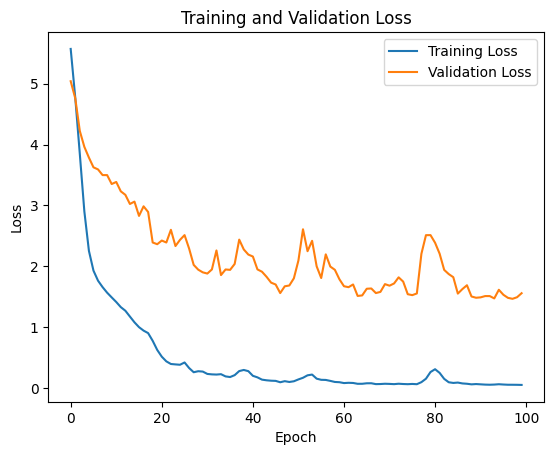

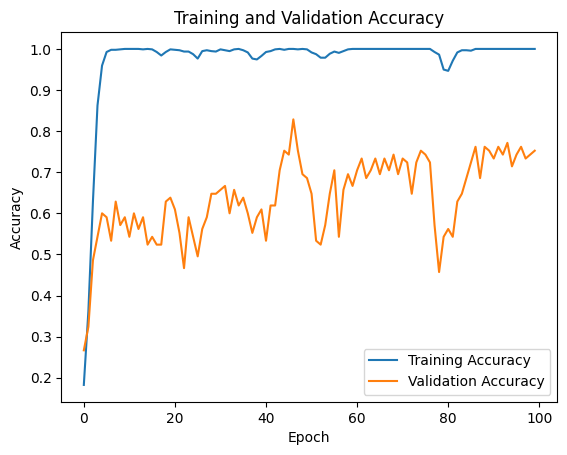

In [87]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.plot(train_accs, label="Training Accuracy")
plt.plot(valid_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


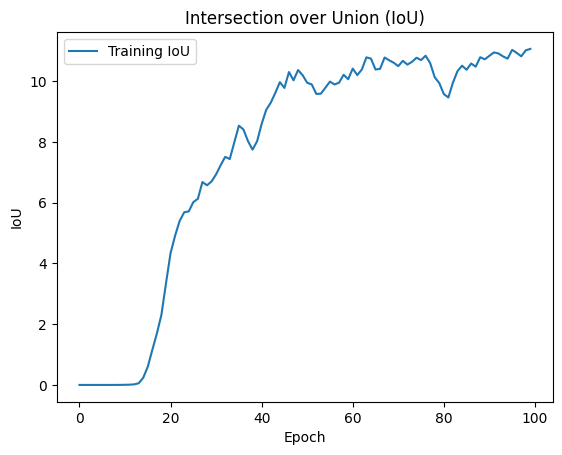

In [89]:
import matplotlib.pyplot as plt

# Plot IoU for training and validation
plt.plot(train_iou, label='Training IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Intersection over Union (IoU)')
plt.legend()
plt.show()


In [90]:
# saving the model as pt file

# create an instance of your model
ObjDetect = model

# define the file path and name for the saved model
save_path = '/content/drive/MyDrive/Colab Notebooks/Project 2 Deep Learning & NN/model50_final.pt'

# save the model's state dictionary to the file path
torch.save(ObjDetect.state_dict(), save_path)

In [91]:
# loading the saved model
import torch

# Define the path to the saved model
path = '/content/drive/MyDrive/Colab Notebooks/Project 2 Deep Learning & NN/model50_final.pt'
# Load the saved model
ObjDetect = torch.load(path)



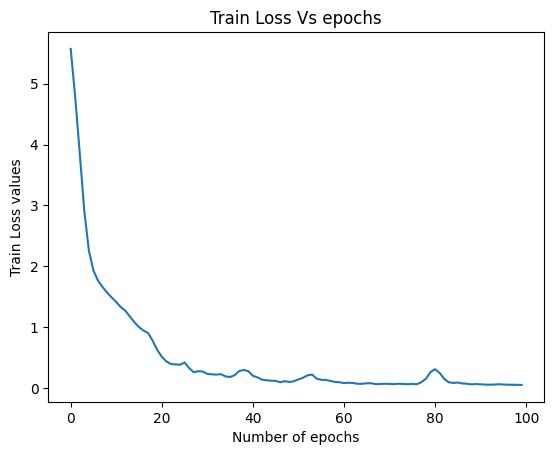

In [92]:
# plot of the training loss values over the course of the training epochs
epocs_run = [i for i in range(0,100)]
plt.plot(epocs_run, train_losses)
plt.title('Train Loss Vs epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Train Loss values')
plt.show()


In [97]:
# Plot the training and validation IoU values
train_iou

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.894775406150561e-05,
 0.001804703106361511,
 0.004076813013876417,
 0.008308563237506174,
 0.017873644792335996,
 0.054400170627593364,
 0.2348200009534289,
 0.5990937565669876,
 1.1535343220635061,
 1.692241255550013,
 2.313271952079598,
 3.342071415335405,
 4.336972106351201,
 4.913924499657786,
 5.4004161355446385,
 5.6831618852573405,
 5.71252344242866,
 6.018031203392935,
 6.128144907682612,
 6.679393603956556,
 6.57294779926414,
 6.6979324524477715,
 6.933035197513881,
 7.233419056672612,
 7.508731295558666,
 7.436735678441244,
 7.986315335510055,
 8.534005454144408,
 8.411350937260405,
 8.027999833454766,
 7.7466379863031,
 8.019615089281128,
 8.590639496755607,
 9.056190637637775,
 9.291090286625623,
 9.613431422602234,
 9.967502933053566,
 9.77806934132779,
 10.301528861537147,
 10.029221485829389,
 10.366336310643746,
 10.196965256735666,
 9.948168954891045,
 9.893560487181725,
 9.58027956406177,
 9.588224995342525,
 9.786152

# 3.Evaluate your model using the test images

In [94]:
#Testing Loop
num_correct = 0
num_total = 0

with torch.no_grad():
    for X, y, z in test_data_loader:
        X, y = X.to(device), y.to(device)
        logits, bboxes = model(X)
        preds = logits.argmax(dim=1)
        num_correct += (preds == y).sum().item()
        num_total += y.size(0)

        bbox_df = pd.DataFrame(bboxes.cpu().numpy(), columns=['Position_1', 'Position_2', 'Position_3', 'Position_4'])
        print(bbox_df)




     Position_1  Position_2  Position_3  Position_4
0    149.010864   69.241707  165.697128   84.797943
1    246.018494   81.759087  267.076843  101.782318
2    258.533539   51.332462  279.097137   70.923317
3    256.934082   81.952065  278.808685  102.578468
4    238.543747   68.075203  258.578247   87.010277
..          ...         ...         ...         ...
256  235.294891  100.344543  255.797531  120.103966
257  160.862610   68.583031  177.664597   84.216553
258  236.534119   83.303635  257.455475  103.010002
259  227.488968   49.345703  246.142532   67.244644
260  254.299789  104.029930  277.105652  125.596382

[261 rows x 4 columns]
Test accuracy for stall numbers: 73.563%


In [98]:
# Compute accuracy
test_acc = 100 * num_correct / num_total
print(f"Test accuracy for stall numbers: {test_acc:.3f}%")

Test accuracy for stall numbers: 73.563%


# 4. Write a four-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


https://www.researchgate.net/publication/370155361_Defining_a_ObjectDetection_Models_for_Cow_Stall_Number_Classification_using_Resnet50